#Option Pricing and Real Price Comparison

The codes provided code snippets cover various aspects of option pricing, from fetching option chain data to calculating option prices and implied volatility.
The Black-Scholes model is used for European options, while the Binomial Option Pricing Model is used for both European and American options.
Implied volatility calculations allow traders to assess the market's expectation of future volatility.
The code provides a practical approach to option pricing and volatility calculation, making it useful for traders and financial analysts.

# Formula/Function

Import necesaay libararies

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import yfinance as yf
import pandas as pd
from datetime import datetime
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

##Black-Schole

**Black-Scholes Option Pricing Model**
This class Black_Scholes calculates option prices and deltas using the Black-Scholes model.

* __init__(self, spot_price, strike_price, dividend_yield, risk_free_rate, time_to_maturity, volatility): Initializes the parameters needed for option pricing.
* d1(self): Calculates the d1 parameter used in the Black-Scholes formula.
* d2(self): Calculates the d2 parameter used in the Black-Scholes formula.
* call_option_price(self): Calculates the price of a call option.
* call_option_delta(self): Calculates the delta of a call option.
* put_option_price(self): Calculates the price of a put option.
* put_option_delta(self): Calculates the delta of a put option.

In [2]:
import numpy as np
from scipy.stats import norm

class Black＿Scholes:
    def __init__(self, spot_price, strike_price, dividend_yield, risk_free_rate, time_to_maturity, volatility):
        self.spot_price = spot_price
        self.strike_price = strike_price
        self.dividend_yield = dividend_yield
        self.risk_free_rate = risk_free_rate
        self.time_to_maturity = time_to_maturity
        self.volatility = volatility

    def d1(self):
        d1 = (np.log(self.spot_price / self.strike_price) + (self.dividend_yield + (self.volatility ** 2) / 2) * self.time_to_maturity) / (self.volatility * np.sqrt(self.time_to_maturity))
        return d1

    def d2(self):
        d1 = self.d1()
        d2 = d1 - self.volatility * np.sqrt(self.time_to_maturity)
        return d2

    def call_option_price(self):
        d1 = self.d1()
        d2 = self.d2()
        call_option_price = self.spot_price * np.exp((self.dividend_yield - self.risk_free_rate) * self.time_to_maturity) * norm.cdf(d1) - self.strike_price * np.exp(-self.risk_free_rate * self.time_to_maturity) * norm.cdf(d2)
        return call_option_price

    def call_option_delta(self):
        d1 = self.d1()
        call_option_delta = np.exp((self.dividend_yield - self.risk_free_rate) * self.time_to_maturity) * norm.cdf(d1)
        return call_option_delta

    def put_option_price(self):
        d1 = self.d1()
        d2 = self.d2()
        put_option_price = self.strike_price * np.exp(-self.risk_free_rate * self.time_to_maturity) * norm.cdf(-d2) - self.spot_price * np.exp((self.dividend_yield - self.risk_free_rate) * self.time_to_maturity) * norm.cdf(-d1)
        return put_option_price

    def put_option_delta(self):
        d1 = self.d1()
        put_option_delta = -np.exp((self.dividend_yield - self.risk_free_rate) * self.time_to_maturity) * norm.cdf(-d1)
        return put_option_delta

##Binomial Tree

**Binomial Option Pricing Model**
This class BinomialOptionPricing implements the Binomial Option Pricing Model to calculate option prices for both European and American options.

* __init__(self, spot_price, strike_price, dividend_yield, risk_free_rate, time_to_maturity, volatility, num_steps): Initializes the parameters needed for binomial option pricing.
* generate_asset_price(self): Generates the asset price tree.
generate_european_call(self): Calculates the price of a European call option.
* generate_american_call(self): Calculates the price of an American call option.
* generate_european_put(self): Calculates the price of a European put option.
* generate_american_put(self): Calculates the price of an American put option.
* european_call_price(self): Returns the price of a European call option.
* american_call_price(self): Returns the price of an American call option.
* european_put_price(self): Returns the price of a European put option.
* american_put_price(self): Returns the price of an American put option.

In [3]:
import numpy as np
import pandas as pd

class BinomialOptionPricing:
    def __init__(self, spot_price, strike_price, dividend_yield, risk_free_rate, time_to_maturity, volatility, num_steps):
        self.spot_price = spot_price
        self.strike_price = strike_price
        self.dividend_yield = dividend_yield
        self.risk_free_rate = risk_free_rate
        self.time_to_maturity = time_to_maturity
        self.volatility = volatility
        self.num_steps = num_steps
        self.delta_t = time_to_maturity / num_steps
        self.u = np.exp(volatility * np.sqrt(self.delta_t))
        self.d = 1 / self.u
        self.r = np.exp(risk_free_rate * self.delta_t)
        self.b = np.exp(dividend_yield * self.delta_t)
        self.q = (self.b - self.d) / (self.u - self.d)
        self.y = self.generate_asset_price()

    def generate_asset_price(self):
        y = np.zeros((self.num_steps + 1, self.num_steps + 1))

        for i in range(self.num_steps + 1):
            for j in range(self.num_steps + 1):
                if i == 0 and j == 0:
                    y[i, j] = self.spot_price
                elif i == j:
                    y[i, j] = y[i-1, j-1] * self.d
                elif i < j:
                    y[i, j] = y[i, j-1] * self.u
                else:
                    y[i, j] = 0

        return y

    def generate_european_call(self):
        x = np.zeros((self.num_steps + 1, self.num_steps + 1))

        for i in range(self.num_steps + 1):
            for j in range(self.num_steps + 1):
                if j == self.num_steps:
                    x[i, j] = max(0, self.y[i, j] - self.strike_price)

        n = 1
        for k in range(self.num_steps + 1 - n):
            for i in range(self.num_steps - n + 1):
                for j in range(self.num_steps):
                    if j <= self.num_steps - 1 and i <= self.num_steps - 1 and i <= j:
                        x[i, j] = (self.q * x[i, j+1] + (1 - self.q) * x[i+1, j+1]) / self.r
            n += 1
        return x

    def generate_american_call(self):
        x = np.zeros((self.num_steps + 1, self.num_steps + 1))

        for i in range(self.num_steps + 1):
            for j in range(self.num_steps + 1):
                if j == self.num_steps:
                    x[i, j] = max(0, self.y[i, j] - self.strike_price)

        n = 1
        for k in range(self.num_steps + 1 - n):
            for i in range(self.num_steps - n + 1):
                for j in range(self.num_steps):
                    if j <= self.num_steps - 1 and i <= self.num_steps - 1 and i <= j:
                        x[i, j] = np.maximum(self.y[i, j] - self.strike_price, (self.q * x[i, j+1] + (1 - self.q) * x[i+1, j+1]) / self.r)

            n += 1
        return x

    def generate_european_put(self):
        x = np.zeros((self.num_steps + 1, self.num_steps + 1))

        for i in range(self.num_steps + 1):
            for j in range(self.num_steps + 1):
                if j == self.num_steps:
                    x[i, j] = max(0, self.strike_price - self.y[i, j])

        n = 1
        for k in range(self.num_steps + 1 - n):
            for i in range(self.num_steps - n + 1):
                for j in range(self.num_steps):
                    if j <= self.num_steps - 1 and i <= self.num_steps - 1 and i <= j:
                        x[i, j] = (self.q * x[i, j+1] + (1 - self.q) * x[i+1, j+1]) / self.r
            n += 1
        return x

    def generate_american_put(self):
        x = np.zeros((self.num_steps + 1, self.num_steps + 1))

        for i in range(self.num_steps + 1):
            for j in range(self.num_steps + 1):
                if j == self.num_steps:
                    x[i, j] = max(0, self.strike_price - self.y[i, j])

        n = 1
        for k in range(self.num_steps + 1 - n):
            for i in range(self.num_steps - n + 1):
                for j in range(self.num_steps):
                    if j <= self.num_steps - 1 and i <= self.num_steps - 1 and i <= j:
                        x[i, j] = np.maximum(self.strike_price - self.y[i, j], (self.q * x[i, j+1] + (1 - self.q) * x[i+1, j+1]) / self.r)

            n += 1
        return x

    def european_call_price(self):
      european_call_price = self.generate_european_call()
      return european_call_price[0, 0]

    def american_call_price(self):
      american_call_price = self.generate_american_call()
      return american_call_price[0, 0]

    def european_put_price(self):
      generate_european_put = self.generate_european_put()
      return generate_european_put[0, 0]

    def american_put_price(self):
      generate_american_put = self.generate_american_put()
      return generate_american_put[0, 0]

# Real Option Data

## Grab Data from Yahoo Finance

1. Ticker and option_chain:
Using the yfinance library, these parts of the code fetch option chain data for a given ticker symbol and expiration date. The option chain data includes information on both calls and puts available for trading.
2. Download Risk-Free Rate:
fetches data for Treasury bond yields using yfinance. It downloads the 6-month T-bill, 5-year, 10-year, and 30-year Treasury bond yields. These yields are often used as proxies for risk-free rates in financial modeling.
3. Historical Data:
fetches historical stock data for the past 52 weeks using yfinance. It then calculates the dividends yield rate and percentage returns for the stock over the given period.

In [4]:
import yfinance as yf
import pandas as pd

ticker_symbol = 'TSLA'
ticker = yf.Ticker(ticker_symbol)

# Retrieve available expiration dates for options
expiration_dates = ticker.options

# Convert expiration dates to a DataFrame for display
if expiration_dates:
    expiration_dates_df = pd.DataFrame(expiration_dates, columns=['Expire Dates'])
    print(expiration_dates_df)
else:
    print('No expiration dates available.')

print('Number of expiration dates:', len(expiration_dates))

   Expire Dates
0    2024-09-06
1    2024-09-13
2    2024-09-20
3    2024-09-27
4    2024-10-04
5    2024-10-11
6    2024-10-18
7    2024-11-15
8    2024-12-20
9    2025-01-17
10   2025-02-21
11   2025-03-21
12   2025-04-17
13   2025-06-20
14   2025-08-15
15   2025-09-19
16   2025-12-19
17   2026-01-16
18   2026-06-18
19   2026-12-18
Number of expiration dates: 20


In [5]:
import yfinance as yf
import pandas as pd
pd.set_option('display.max_rows', None)


#expiration_date = '2025-03-21'  # Replace '2024-06-19' with your desired expiration date
expiration_date = expiration_dates[5]

# Create a Ticker object
ticker = yf.Ticker(ticker_symbol)

# Retrieve the option chain for the specified expiration date
option_chain = ticker.option_chain(expiration_date)

# Convert the calls and puts data into DataFrames
calls_df = pd.DataFrame(option_chain.calls)
puts_df = pd.DataFrame(option_chain.puts)
expiration_date = pd.to_datetime(expiration_date)
expiration_date

print(f"Total Call Numbers is {len(calls_df)}")
print(f"Total Put Numbers is {len(puts_df)}")

Total Call Numbers is 31
Total Put Numbers is 27


In [6]:
try:
  assert expiration_date > pd.Timestamp(datetime.today().date())
except AssertionError:
  raise ValueError("Change date later than today")

In [7]:
difference = expiration_date - pd.Timestamp(datetime.today().date())
difference.days

36

In [8]:
#risk-free
import yfinance as yf
from datetime import datetime

# Define the ticker symbols for Treasury bonds
tickers = ["^IRX", "^FVX", "^TNX", "^TYX"]  # 6-month T-bill, 5-year, 10-year, 30-year

# Fetch data
Risk_Free_Rate = yf.download(tickers, start = datetime.today().date() - pd.Timedelta(days = 7), end=datetime.today().date(), interval="1wk")
# Filter only 'Adj Close' columns
adj_close_columns = [col for col in Risk_Free_Rate.columns if 'Adj Close' in col]
Risk_Free_Rate_adj_close = Risk_Free_Rate[adj_close_columns]
# Clean column names
Risk_Free_Rate_adj_close.columns = [col[1] for col in Risk_Free_Rate_adj_close.columns]
Risk_Free_Rate = Risk_Free_Rate_adj_close.reset_index()
Risk_Free_Rate = Risk_Free_Rate.rename(columns = {"^IRX": "TB13W", "^FVX": "TB5", "^TNX": "TB10", "^TYX": "TB30"})
Risk_Free_Rate["Date"] = pd.to_datetime(Risk_Free_Rate["Date"])
Risk_Free_Rate.iloc[:, 1:] = Risk_Free_Rate.iloc[:, 1:]/100

[*********************100%***********************]  4 of 4 completed


In [9]:
Risk_Free = Risk_Free_Rate["TB13W"].tail(1).values[0]

In [10]:
import yfinance as yf

ticker = yf.Ticker(ticker_symbol)

# Retrieve historical data for the past 3 months
historical_data = ticker.history(period= '1y', interval='1wk')
historical_data = historical_data.reset_index()
historical_data['Date'] = pd.to_datetime(historical_data['Date'])
historical_data['Date'] = historical_data['Date'].dt.strftime('%Y-%m-%d')
historical_data.head(3)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2023-09-04,245.000000,258.000000,243.270004,248.500000,480110000,0.0,0.0
1,2023-09-11,264.269989,278.980011,260.609985,274.390015,663474100,0.0,0.0
2,2023-09-18,271.160004,273.929993,244.479996,244.880005,574817000,0.0,0.0


In [11]:
historical_data['Dividends_Yield'] = historical_data['Dividends']/historical_data['Close']
dividend_yield_rate = historical_data['Dividends_Yield'].mean() * 52
dividend_yield_rate

0.0

In [12]:
historical_data['Return'] = historical_data['Close'].pct_change()
historical_data = historical_data.fillna(0)
historical_data.round(3).head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Dividends_Yield,Return
0,2023-09-04,245.00,258.00,243.27,248.50,480110000,0.0,0.0,0.0,0.000
1,2023-09-11,264.27,278.98,260.61,274.39,663474100,0.0,0.0,0.0,0.104
2,2023-09-18,271.16,273.93,244.48,244.88,574817000,0.0,0.0,0.0,-0.108
3,2023-09-25,243.38,254.77,234.58,250.22,588632500,0.0,0.0,0.0,0.022
4,2023-10-02,244.81,263.60,242.62,260.53,592623500,0.0,0.0,0.0,0.041


In [13]:
#Calculate Volatilty using standard deviation of Market
volatility_past = historical_data['Return'].std()/np.sqrt(1/52) * np.sqrt(12)
volatility_past

1.8574698815552384

In [14]:
import yfinance as yf

# Create a Ticker object
ticker = yf.Ticker(ticker_symbol)
# Retrieve the real-time price (most recent price)
real_time_data = ticker.history(period='1d')
# Extract the spot price (most recent closing price)
if not real_time_data.empty:
    spot_price = real_time_data['Close'].iloc[-1]
    print(f"Spot price for {ticker_symbol}: ${spot_price:.2f}")
else:
    print('No real-time data available.')

Spot price for TSLA: $219.41


## Call Option

### Use implied volatility to get price

Option Price Calculation:
* num_steps: Sets the number of steps for the Binomial Option Pricing Model.
* calls_df_price['BS_Price']: Calculates the Black-Scholes call option price for each row using the implied volatility.
* calls_df_price['BT_EU_Price']: Calculates the Binomial European call option price for each row using the implied volatility.
* calls_df_price['BT_AM_Price']: Calculates the Binomial American call option price for each using the implied volatility.

In [15]:
calls_df.head(3)

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,TSLA241011C00130000,2024-08-30 17:16:31+00:00,130.0,81.63,90.15,91.25,0.000000,0.000000,6,6,1.030278,True,REGULAR,USD
1,TSLA241011C00150000,2024-09-04 17:45:03+00:00,150.0,72.20,70.70,71.70,9.699997,15.519995,22,25,0.852418,True,REGULAR,USD
2,TSLA241011C00170000,2024-09-04 18:29:15+00:00,170.0,54.22,49.90,52.95,9.620003,21.569513,41,41,0.643436,True,REGULAR,USD


In [16]:
calls_df = calls_df[['strike', 'lastPrice', 'bid', 'ask','impliedVolatility']]
calls_df.insert(0, 'Tickers', ticker_symbol)
calls_df['Spot Price'] = spot_price.round(2)
calls_df['Volatility_Past'] = volatility_past
calls_df_price = calls_df.copy()
calls_df_price.head(3)

,Tickers,strike,lastPrice,bid,ask,impliedVolatility,Spot Price,Volatility_Past
0,TSLA,130.0,81.63,90.15,91.25,1.030278,219.41,1.85747
1,TSLA,150.0,72.20,70.70,71.70,0.852418,219.41,1.85747
2,TSLA,170.0,54.22,49.90,52.95,0.643436,219.41,1.85747


In [17]:
def calculate_bs_call_price(row, spot_price, strike_price, dividend_yield, risk_free_rate, time_to_maturity, volatility):
    bs = Black＿Scholes(spot_price, strike_price, dividend_yield, risk_free_rate, time_to_maturity, volatility)
    return bs.call_option_price()
def calculate_bt_call_eu_price(row, spot_price, strike_price, dividend_yield, risk_free_rate, time_to_maturity, volatility, num_steps):
    bt = BinomialOptionPricing(spot_price, strike_price, dividend_yield,risk_free_rate, time_to_maturity, volatility, num_steps)
    return bt.european_call_price()
def calculate_bt_call_am_price(row, spot_price, strike_price, dividend_yield, risk_free_rate, time_to_maturity, volatility, num_steps):
    bt = BinomialOptionPricing(spot_price, strike_price, dividend_yield,risk_free_rate, time_to_maturity, volatility, num_steps)
    return bt.american_call_price()

In [18]:
num_steps = 15

In [19]:
# Assuming calls_df is your DataFrame containing options data
calls_df_price['BS_Price'] = calls_df_price.apply(lambda row: calculate_bs_call_price(row, spot_price, row['strike'], Risk_Free - dividend_yield_rate, Risk_Free, difference.days/365, row['impliedVolatility']), axis=1)
calls_df_price['BS_Price'] = calls_df_price['BS_Price'].round(2)

# Assuming calls_df is your DataFrame containing options data
calls_df_price['BT_EU_Price'] = calls_df_price.apply(lambda row: calculate_bt_call_eu_price(row, spot_price, row['strike'], Risk_Free - dividend_yield_rate, Risk_Free, difference.days/365, row['impliedVolatility'], num_steps), axis=1)
calls_df_price['BT_EU_Price'] = calls_df_price['BT_EU_Price'].round(2)

# Assuming calls_df is your DataFrame containing options data
calls_df_price['BT_AM_Price'] = calls_df_price.apply(lambda row: calculate_bt_call_am_price(row, spot_price, row['strike'], Risk_Free - dividend_yield_rate, Risk_Free, difference.days/365, row['impliedVolatility'], num_steps), axis=1)
calls_df_price['BT_AM_Price'] = calls_df_price['BT_AM_Price'].round(2)

In [20]:
calls_df_price = calls_df_price[['Tickers','Spot Price', 'strike', 'lastPrice', 'bid', 'ask', 'impliedVolatility', 'Volatility_Past','BS_Price', 'BT_EU_Price', 'BT_AM_Price']]

In [21]:
# Define the custom formatting function
def custom_format(x):
    if isinstance(x, (int, float)):
        if abs(x) >= 10000:
            return f'{x:.2e}'
    return x
calls_df_price = calls_df_price.applymap(custom_format)

In [22]:
calls_df_price

,Tickers,Spot Price,strike,lastPrice,bid,ask,impliedVolatility,Volatility_Past,BS_Price,BT_EU_Price,BT_AM_Price
0,TSLA,219.41,130.0,81.63,90.15,91.25,1.030278,1.85747,91.20,91.22,91.22
1,TSLA,219.41,150.0,72.20,70.70,71.70,0.852418,1.85747,71.76,71.72,71.72
2,TSLA,219.41,170.0,54.22,49.90,52.95,0.643436,1.85747,52.05,51.94,51.94
3,TSLA,219.41,175.0,42.62,47.60,48.60,0.711062,1.85747,48.65,48.76,48.76
4,TSLA,219.41,180.0,34.47,43.25,44.00,0.681278,1.85747,44.17,44.22,44.22
5,TSLA,219.41,190.0,28.24,35.05,36.00,0.652347,1.85747,36.02,36.00,36.00
6,TSLA,219.41,195.0,29.10,31.15,31.95,0.630985,1.85747,32.02,32.19,32.19
7,TSLA,219.41,200.0,28.00,27.65,28.50,0.624454,1.85747,28.51,28.71,28.71
8,TSLA,219.41,205.0,25.60,24.30,24.95,0.610478,1.85747,25.02,25.05,25.05
9,TSLA,219.41,210.0,21.50,21.25,21.90,0.603947,1.85747,21.93,21.77,21.77


### Use volatility from the past to get the price

In [23]:
calls_df_volatility_price = calls_df.copy()

1. Adjusting Calls DataFrame for Volatility Price:
* Creates a copy of the original DataFrame for calculating option prices using the past volatility.
2. Option Price Calculation using Past Volatility:
* calls_df_volatility_price['BS_Price']: Calculates the Black-Scholes call option price for each row in the DataFrame using the past volatility.
* calls_df_volatility_price['BT_EU_Price']: Calculates the European call option price for each row in the DataFrame using the past volatility.
* calls_df_volatility_price['BT_AM_Price']: Calculates the American call option price for each row in the DataFrame using the past volatility.

In [24]:
# Assuming calls_df is your DataFrame containing options data
calls_df_volatility_price['BS_Price'] = calls_df_volatility_price.apply(lambda row: calculate_bs_call_price(row, spot_price, row['strike'], Risk_Free - dividend_yield_rate, Risk_Free, difference.days/365, row['Volatility_Past']), axis=1)
calls_df_volatility_price['BS_Price'] = calls_df_volatility_price['BS_Price'].round(2)

# Assuming calls_df is your DataFrame containing options data
calls_df_volatility_price['BT_EU_Price'] = calls_df_volatility_price.apply(lambda row: calculate_bt_call_eu_price(row, spot_price, row['strike'], Risk_Free - dividend_yield_rate, Risk_Free, difference.days/365, row['Volatility_Past'], num_steps), axis=1)
calls_df_volatility_price['BT_EU_Price'] = calls_df_volatility_price['BT_EU_Price'].round(2)

# Assuming calls_df is your DataFrame containing options data
calls_df_volatility_price['BT_AM_Price'] = calls_df_volatility_price.apply(lambda row: calculate_bt_call_am_price(row, spot_price, row['strike'], Risk_Free - dividend_yield_rate, Risk_Free, difference.days/365, row['Volatility_Past'], num_steps), axis=1)
calls_df_volatility_price['BT_AM_Price'] = calls_df_volatility_price['BT_AM_Price'].round(2)

In [25]:
calls_df_volatility_price = calls_df_volatility_price[['Tickers','Spot Price', 'strike', 'lastPrice', 'bid', 'ask', 'impliedVolatility', 'Volatility_Past','BS_Price', 'BT_EU_Price', 'BT_AM_Price']]

In [26]:
# Define the custom formatting function
def custom_format(x):
    if isinstance(x, (int, float)):
        if abs(x) >= 10000:
            return f'{x:.2e}'
    return x
calls_df_volatility_price = calls_df_volatility_price.applymap(custom_format)

In [27]:
calls_df_volatility_price

,Tickers,Spot Price,strike,lastPrice,bid,ask,impliedVolatility,Volatility_Past,BS_Price,BT_EU_Price,BT_AM_Price
0,TSLA,219.41,130.0,81.63,90.15,91.25,1.030278,1.85747,99.56,99.58,99.58
1,TSLA,219.41,150.0,72.20,70.70,71.70,0.852418,1.85747,85.89,86.09,86.09
2,TSLA,219.41,170.0,54.22,49.90,52.95,0.643436,1.85747,73.91,74.35,74.35
3,TSLA,219.41,175.0,42.62,47.60,48.60,0.711062,1.85747,71.16,71.42,71.42
4,TSLA,219.41,180.0,34.47,43.25,44.00,0.681278,1.85747,68.52,68.49,68.49
5,TSLA,219.41,190.0,28.24,35.05,36.00,0.652347,1.85747,63.50,62.87,62.87
6,TSLA,219.41,195.0,29.10,31.15,31.95,0.630985,1.85747,61.13,60.95,60.95
7,TSLA,219.41,200.0,28.00,27.65,28.50,0.624454,1.85747,58.85,59.03,59.03
8,TSLA,219.41,205.0,25.60,24.30,24.95,0.610478,1.85747,56.65,57.10,57.10
9,TSLA,219.41,210.0,21.50,21.25,21.90,0.603947,1.85747,54.53,55.18,55.18


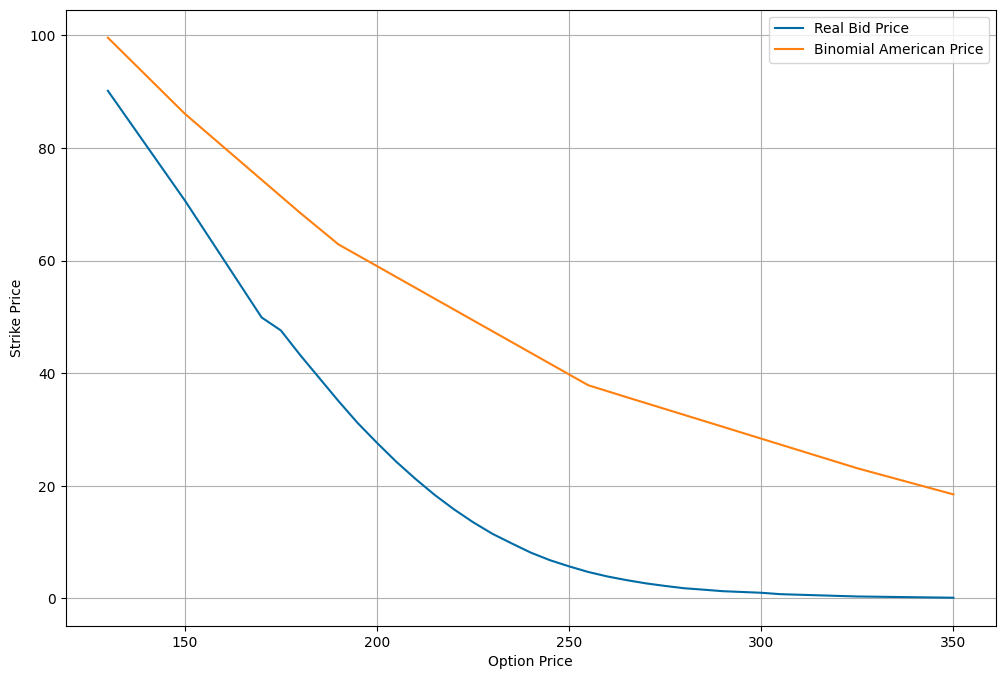

In [28]:
import matplotlib.pyplot as plt
plt.style.use("tableau-colorblind10")

plt.figure(figsize=(12, 8))

calls_df_volatility_price = calls_df_volatility_price[calls_df_volatility_price['bid'] != 0]

plt.plot(calls_df_volatility_price["strike"], calls_df_volatility_price["bid"], label = "Real Bid Price")
plt.plot(calls_df_volatility_price["strike"], calls_df_volatility_price['BT_AM_Price'], label = "Binomial American Price")

plt.xlabel("Option Price")
plt.ylabel("Strike Price")
plt.legend()
plt.grid("whitegray")
plt.show()

## Put Option

### Use implied volatility to get price

Option Price Calculation for Puts:
* puts_df_price['BS_Price']: Calculates Black-Scholes put option price for each row using the implied volatility.
* puts_df_price['BT_EU_Price']: Calculates the Binomial European put option price for each row using the implied volatility.
* puts_df_price['BT_AM_Price']: Calculates the Binomial American put option price for each row using the implied volatility

In [29]:
puts_df = puts_df[['strike', 'lastPrice', 'bid', 'ask','impliedVolatility']]
puts_df.insert(0, 'Tickers', ticker_symbol)
puts_df.head()

,Tickers,strike,lastPrice,bid,ask,impliedVolatility
0,TSLA,125.0,0.29,0.18,0.38,0.839357
1,TSLA,135.0,0.41,0.38,0.58,0.801760
2,TSLA,140.0,0.47,0.47,0.69,0.774416
3,TSLA,145.0,0.64,0.52,0.81,0.740481
4,TSLA,150.0,0.78,0.66,0.98,0.717288


In [30]:
puts_df['Spot Price'] = spot_price.round(2)
puts_df['Volatility_Past'] = volatility_past
puts_df_price = puts_df.copy()
puts_df_price.head(3)

,Tickers,strike,lastPrice,bid,ask,impliedVolatility,Spot Price,Volatility_Past
0,TSLA,125.0,0.29,0.18,0.38,0.839357,219.41,1.85747
1,TSLA,135.0,0.41,0.38,0.58,0.801760,219.41,1.85747
2,TSLA,140.0,0.47,0.47,0.69,0.774416,219.41,1.85747


In [31]:
def calculate_bs_put_price(row, spot_price, strike_price, dividend_yield, risk_free_rate, time_to_maturity, volatility):
    bs = Black＿Scholes(spot_price, strike_price, Risk_Free - dividend_yield, risk_free_rate, time_to_maturity, volatility)
    return bs.put_option_price()
def calculate_bt_put_eu_price(row, spot_price, strike_price, dividend_yield, risk_free_rate, time_to_maturity, volatility, num_steps):
    bt = BinomialOptionPricing(spot_price, strike_price, Risk_Free - dividend_yield,risk_free_rate, time_to_maturity, volatility, num_steps)
    return bt.european_put_price()
def calculate_bt_put_am_price(row, spot_price, strike_price, dividend_yield, risk_free_rate, time_to_maturity, volatility, num_steps):
    bt = BinomialOptionPricing(spot_price, strike_price, Risk_Free - dividend_yield,risk_free_rate, time_to_maturity, volatility, num_steps)
    return bt.american_put_price()

In [32]:
num_steps = 15

In [33]:
# Assuming calls_df is your DataFrame containing options data
puts_df_price['BS_Price'] = puts_df_price.apply(lambda row: calculate_bs_put_price(row, spot_price, row['strike'], dividend_yield_rate, Risk_Free, difference.days/365, row['impliedVolatility']), axis=1)
puts_df_price['BS_Price'] = puts_df_price['BS_Price'].round(2)

# Assuming calls_df is your DataFrame containing options data
puts_df_price['BT_EU_Price'] = puts_df_price.apply(lambda row: calculate_bt_put_eu_price(row, spot_price, row['strike'], dividend_yield_rate, Risk_Free, difference.days/365, row['impliedVolatility'], num_steps), axis=1)
puts_df_price['BT_EU_Price'] = puts_df_price['BT_EU_Price'].round(2)

# Assuming calls_df is your DataFrame containing options data
puts_df_price['BT_AM_Price'] = puts_df_price.apply(lambda row: calculate_bt_put_am_price(row, spot_price, row['strike'], dividend_yield_rate, Risk_Free, difference.days/365, row['impliedVolatility'], num_steps), axis=1)
puts_df_price['BT_AM_Price'] = puts_df_price['BT_AM_Price'].round(2)

In [34]:
puts_df_price = puts_df_price[['Tickers','Spot Price', 'strike', 'lastPrice', 'bid', 'ask', 'impliedVolatility', 'Volatility_Past','BS_Price', 'BT_EU_Price', 'BT_AM_Price']]

In [35]:
# Define the custom formatting function
def custom_format(x):
    if isinstance(x, (int, float)):
        if abs(x) >= 10000:
            return f'{x:.2e}'
    return x
puts_df_price = puts_df_price.applymap(custom_format)

In [36]:
puts_df_price

,Tickers,Spot Price,strike,lastPrice,bid,ask,impliedVolatility,Volatility_Past,BS_Price,BT_EU_Price,BT_AM_Price
0,TSLA,219.41,125.0,0.29,0.18,0.38,0.839357,1.85747,0.24,0.23,0.23
1,TSLA,219.41,135.0,0.41,0.38,0.58,0.801760,1.85747,0.42,0.37,0.37
2,TSLA,219.41,140.0,0.47,0.47,0.69,0.774416,1.85747,0.51,0.42,0.42
3,TSLA,219.41,145.0,0.64,0.52,0.81,0.740481,1.85747,0.58,0.50,0.50
4,TSLA,219.41,150.0,0.78,0.66,0.98,0.717288,1.85747,0.72,0.71,0.71
5,TSLA,219.41,155.0,1.05,1.00,1.25,0.711185,1.85747,1.00,1.02,1.02
6,TSLA,219.41,160.0,1.12,1.08,1.43,0.674320,1.85747,1.12,1.12,1.13
7,TSLA,219.41,165.0,1.51,1.38,1.84,0.660404,1.85747,1.45,1.38,1.38
8,TSLA,219.41,170.0,1.95,1.77,2.05,0.634159,1.85747,1.72,1.57,1.58
9,TSLA,219.41,175.0,2.42,2.23,2.58,0.619144,1.85747,2.18,2.20,2.21


### Use volatility from the past to get the price

Option Price Calculation using Past Volatility for Puts:
* puts_df_volatility_price['BS_Price']: Calculates the Black-Scholes put option price for each row in the DataFrame using the past volatility.
* puts_df_volatility_price['BT_EU_Price']: Calculates the Binomial European put option price for each row using the past volatility.
* puts_df_volatility_price['BT_AM_Price']: Calculates the Binomial American put option price for each row using the past volatility.

In [37]:
puts_df_volatility_price = puts_df.copy()

In [38]:
puts_df_volatility_price.head()

,Tickers,strike,lastPrice,bid,ask,impliedVolatility,Spot Price,Volatility_Past
0,TSLA,125.0,0.29,0.18,0.38,0.839357,219.41,1.85747
1,TSLA,135.0,0.41,0.38,0.58,0.801760,219.41,1.85747
2,TSLA,140.0,0.47,0.47,0.69,0.774416,219.41,1.85747
3,TSLA,145.0,0.64,0.52,0.81,0.740481,219.41,1.85747
4,TSLA,150.0,0.78,0.66,0.98,0.717288,219.41,1.85747


In [39]:
# Assuming calls_df is your DataFrame containing options data
puts_df_volatility_price['BS_Price'] = puts_df_volatility_price.apply(lambda row: calculate_bs_put_price(row, spot_price, row['strike'], dividend_yield_rate, Risk_Free, difference.days/365, row['Volatility_Past']), axis=1)
puts_df_volatility_price['BS_Price'] = puts_df_volatility_price['BS_Price'].round(2)

# Assuming calls_df is your DataFrame containing options data
puts_df_volatility_price['BT_EU_Price'] = puts_df_volatility_price.apply(lambda row: calculate_bt_put_eu_price(row, spot_price, row['strike'], dividend_yield_rate, Risk_Free, difference.days/365, row['Volatility_Past'], num_steps), axis=1)
puts_df_volatility_price['BT_EU_Price'] = puts_df_volatility_price['BT_EU_Price'].round(2)

# Assuming calls_df is your DataFrame containing options data
puts_df_volatility_price['BT_AM_Price'] = puts_df_volatility_price.apply(lambda row: calculate_bt_put_am_price(row, spot_price, row['strike'], dividend_yield_rate, Risk_Free, difference.days/365, row['Volatility_Past'], num_steps), axis=1)
puts_df_volatility_price['BT_AM_Price'] = puts_df_volatility_price['BT_AM_Price'].round(2)

In [40]:
puts_df_volatility_price = puts_df_volatility_price[['Tickers','Spot Price', 'strike', 'lastPrice', 'bid', 'ask', 'impliedVolatility', 'Volatility_Past','BS_Price', 'BT_EU_Price', 'BT_AM_Price']]

In [41]:
# Define the custom formatting function
def custom_format(x):
    if isinstance(x, (int, float)):
        if abs(x) >= 10000:
            return f'{x:.2e}'
    return x
puts_df_volatility_price = puts_df_volatility_price.applymap(custom_format)

In [42]:
puts_df_volatility_price

,Tickers,Spot Price,strike,lastPrice,bid,ask,impliedVolatility,Volatility_Past,BS_Price,BT_EU_Price,BT_AM_Price
0,TSLA,219.41,125.0,0.29,0.18,0.38,0.839357,1.85747,8.23,8.40,8.42
1,TSLA,219.41,135.0,0.41,0.38,0.58,0.801760,1.85747,10.91,10.67,10.68
2,TSLA,219.41,140.0,0.47,0.47,0.69,0.774416,1.85747,12.42,11.87,11.90
3,TSLA,219.41,145.0,0.64,0.52,0.81,0.740481,1.85747,14.03,13.91,13.94
4,TSLA,219.41,150.0,0.78,0.66,0.98,0.717288,1.85747,15.75,15.95,15.98
5,TSLA,219.41,155.0,1.05,1.00,1.25,0.711185,1.85747,17.57,17.99,18.03
6,TSLA,219.41,160.0,1.12,1.08,1.43,0.674320,1.85747,19.50,20.03,20.07
7,TSLA,219.41,165.0,1.51,1.38,1.84,0.660404,1.85747,21.54,22.07,22.11
8,TSLA,219.41,170.0,1.95,1.77,2.05,0.634159,1.85747,23.67,24.12,24.15
9,TSLA,219.41,175.0,2.42,2.23,2.58,0.619144,1.85747,25.90,26.16,26.20


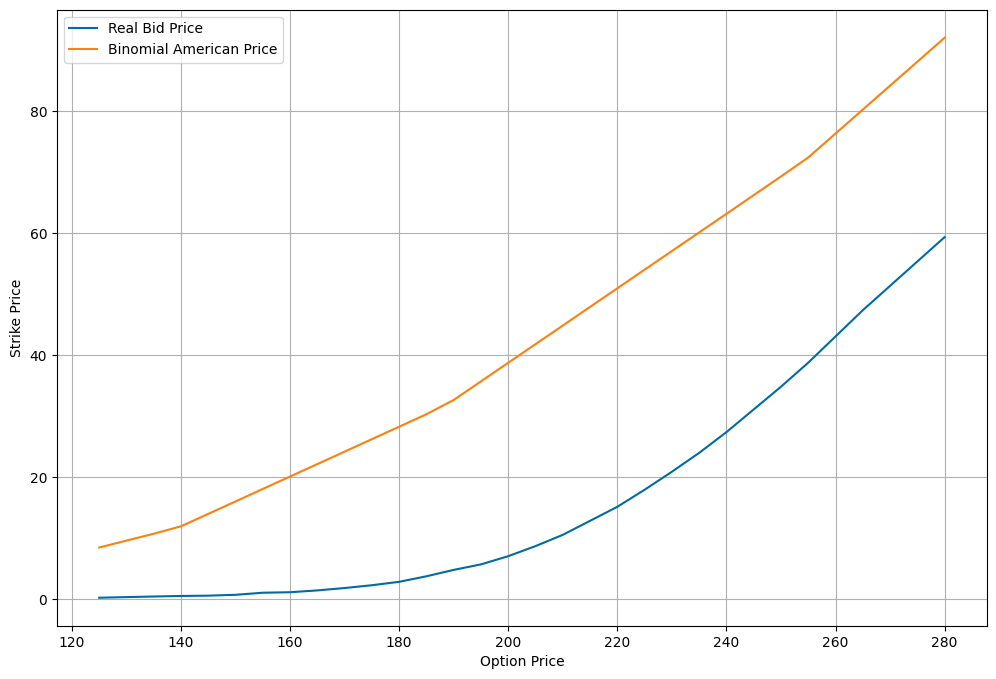

In [43]:
import matplotlib.pyplot as plt
plt.style.use("tableau-colorblind10")

plt.figure(figsize=(12, 8))

puts_df_volatility_price = puts_df_volatility_price[puts_df_volatility_price['bid'] != 0]

plt.plot(puts_df_volatility_price["strike"], puts_df_volatility_price["bid"], linestyle='-', label = "Real Bid Price")
plt.plot(puts_df_volatility_price["strike"], puts_df_volatility_price['BT_AM_Price'], linestyle='-', label = "Binomial American Price")

plt.xlabel("Option Price")
plt.ylabel("Strike Price")
plt.legend()
plt.grid("whitegray")
plt.show()

# Run Option Value by Inputting Parameters Manually

## Black-Schole

### Call Option

1. Define Parameters:
* spot_price: Current stock price.
* strike_price: Option strike price.
* time_to_maturity: Time to option expiration in years.
* volatility: Volatility of the underlying stock.
* risk_free_rate: Risk-free interest rate.
* dividend: Dividend yield rate.
* dividend_yield: Dividend yield calculated as the difference between risk-free rate and dividend yield rate.
2. Create Black-Scholes Option Object:
* Black_Schole_Option = Black＿Scholes(...): Initialize a Black-Scholes option object with the provided parameters.

#### Calculate Price by Manual Input of Data


In [44]:
import numpy as np
import pandas as pd
from scipy.stats import norm
# Example usage:
spot_price = 116.75  # Current stock price
strike_price = 50.0   # Option strike price
time_to_maturity = difference.days/365  # Time to option expiration in years
#time_to_maturity = 3/12
volatility = 0.00001 #np.sqrt(0.1)  # Volatility of the underlying stock
risk_free_rate = Risk_Free # Risk-free interest rate
#risk_free_rate = 0.0425 # Risk-free interest rate
dividend =  dividend_yield_rate
#dividend =  0.0125
dividend_yield =  risk_free_rate - dividend

In [45]:
Black_Schole_Option = Black＿Scholes(spot_price, strike_price, dividend_yield, risk_free_rate, time_to_maturity, volatility)

In [46]:
print(f"d1 is {Black_Schole_Option.d1():.3f}\nd2 is {Black_Schole_Option.d2():.3f}")
print(f"N(d1) is {norm.cdf(Black_Schole_Option.d1()):.3f}\nN(d2) is {norm.cdf(Black_Schole_Option.d2()):.3f}")
print(f"Call Value is {Black_Schole_Option.call_option_price():.3f}\nCall Delta is {Black_Schole_Option.call_option_delta():.3f}")

d1 is 271574.681
d2 is 271574.681
N(d1) is 1.000
N(d2) is 1.000
Call Value is 66.993
Call Delta is 1.000


#### Reverse calculation to get volatility

1. Parameters:
* initial_guess: Initial guess for the volatility.
* tolerance: Tolerance level for convergence.
* max_iterations: Maximum number of iterations for convergence.
2. implied_call_volatility Function:
* Calculates the Black-Scholes call price using the provided volatility.
* Uses the Newton-Raphson method to iteratively refine the volatility until the calculated option price matches the observed call price within the specified tolerance.
* Returns the implied volatility.

In [47]:
initial_guess = 0.5
tolerance = 0.001
max_iterations = 100000

In [48]:
def implied_call_volatility(call_price, initial_guess=initial_guess, tolerance=tolerance, max_iterations=max_iterations):
    def black_scholes_call_price(volatility):
        Black_Schole_Option.volatility = volatility
        return Black_Schole_Option.call_option_price()

    # Newton-Raphson method
    vol = initial_guess
    for i in range(max_iterations):
        option_price = black_scholes_call_price(vol)
        vega = Black_Schole_Option.call_option_delta() * Black_Schole_Option.spot_price * np.exp(-Black_Schole_Option.dividend_yield * Black_Schole_Option.time_to_maturity) / np.sqrt(2 * np.pi * Black_Schole_Option.time_to_maturity)

        if np.abs(option_price - call_price) < tolerance:
            return vol

        vol -= (option_price - call_price) / vega

    return np.nan  # If not found within tolerance

call_price = 67.32
implied_vol = implied_call_volatility(call_price)
rounded_implied_vol = round(float(implied_vol), 3)
print("Implied Volatility Call:", rounded_implied_vol)

Implied Volatility Call: 1.399


### Put Option

#### Calculate Price by Manual Input of Data

Similiar to previous section

In [49]:
import numpy as np
import pandas as pd
from scipy.stats import norm
# Example usage:
spot_price = 516.57  # Current stock price
strike_price = 395.0   # Option strike price
#time_to_maturity = difference.days/365  # Time to option expiration in years
time_to_maturity = 3/12
volatility = 0.421576 #np.sqrt(0.1)  # Volatility of the underlying stock
#risk_free_rate = Risk_Free # Risk-free interest rate
risk_free_rate = 0.0425 # Risk-free interest rate
#dividend =  dividend_yield_rate
dividend =  0.0125
dividend_yield =  risk_free_rate - dividend

In [50]:
Black_Schole_Option = Black＿Scholes(spot_price, strike_price, dividend_yield, risk_free_rate, time_to_maturity, volatility)

In [51]:
print(f"d1 is {Black_Schole_Option.d1():.3f}\nd2 is {Black_Schole_Option.d2():.3f}")
print(f"N(d1) is {norm.cdf(Black_Schole_Option.d1()):.3f}\nN(d2) is {norm.cdf(Black_Schole_Option.d2()):.3f}")
print(f"Put Value is {Black_Schole_Option.put_option_price():.3f}\nPut Delta is {Black_Schole_Option.put_option_delta():.3f}")

d1 is 1.414
d2 is 1.203
N(d1) is 0.921
N(d2) is 0.886
Put Value is 4.211
Put Delta is -0.078


#### Reverse calculation to get volatility

Similar to previous section but use put option price

In [52]:
initial_guess = 0.5
tolerance = 0.001
max_iterations = 10000

In [53]:
def implied_put_volatility(put_price, spot_price, strike_price, dividend_yield, risk_free_rate, time_to_maturity, initial_guess=initial_guess, tolerance=tolerance, max_iterations=max_iterations):
    def black_scholes_put_price(volatility):
        bs = Black_Scholes(spot_price, strike_price, dividend_yield, risk_free_rate, time_to_maturity, volatility)
        return bs.put_option_price()

    # Newton-Raphson method
    vol = initial_guess
    for _ in range(max_iterations):
        option_price = black_scholes_put_price(vol)
        vega = (black_scholes_put_price(vol * 1.001) - black_scholes_put_price(vol)) / (0.001 * vol)

        if abs(option_price - put_price) < tolerance:
            return vol

        vol -= (option_price - put_price) / vega

    return np.nan  # If not found within tolerance

put_price = 0.04
implied_vol = implied_put_volatility(put_price, spot_price, strike_price, dividend_yield, risk_free_rate, time_to_maturity)
rounded_implied_vol = round(float(implied_vol), 3)
print("Implied Volatility Put:", rounded_implied_vol)


Implied Volatility Put: 0.2


## Binomial Tree

### Call Option

1. Define Parameters:
* spot_price: Current stock price.
* strike_price: Option strike price.
* time_to_maturity: Time to option expiration in years.
* volatility: Volatility of the underlying stock.
* risk_free_rate: Risk-free interest rate.
* dividend_yield: Dividend yield rate.
* num_steps: Number of steps in the binomial tree.
2. Create Binomial Option Pricing Object:
Initialize a BinomialOptionPricing object with the provided parameters.
3. Generate Asset Prices:
Generate the asset price tree using generate_asset_price() method and store it in a DataFrame.
4. Generate Option Prices:
* Generate the European call option prices using generate_european_call() method and store them in a DataFrame.
* Generate the American call option prices using generate_american_call() method and store them in a DataFrame.

#### Calculate Price by Manual Input of Data



In [54]:
import numpy as np

spot_price = 3790 # Current stock price
strike_price = 2000   # Option strike price
#time_to_maturity = difference.days/365  # Time to option expiration in years
time_to_maturity = 3/12
volatility = 0.3 #np.sqrt(0.1)  # Volatility of the underlying stock
#risk_free_rate = Risk_Free # Risk-free interest rate
risk_free_rate = 0.03 # Risk-free interest rate
#dividend =  dividend_yield_rate
dividend =  0.02
dividend_yield =  risk_free_rate - dividend

num_steps = 10

binomial_tree_option = BinomialOptionPricing(spot_price, strike_price, dividend_yield, risk_free_rate, time_to_maturity, volatility, num_steps)

In [55]:
Asset_Price_df = pd.DataFrame(binomial_tree_option.generate_asset_price())
Asset_Price_df = Asset_Price_df.round(2)
#Asset_Price_df.replace(0, '', inplace=True)Asset_Price_df
Asset_Price_df

,0,1,2,3,4,5,6,7,8,9,10
0,3790.0,3974.11,4167.16,4369.59,4581.85,4804.42,5037.81,5282.53,5539.14,5808.22,6090.36
1,0.0,3614.42,3790.00,3974.11,4167.16,4369.59,4581.85,4804.42,5037.81,5282.53,5539.14
2,0.0,0.00,3446.98,3614.42,3790.00,3974.11,4167.16,4369.59,4581.85,4804.42,5037.81
3,0.0,0.00,0.00,3287.29,3446.98,3614.42,3790.00,3974.11,4167.16,4369.59,4581.85
4,0.0,0.00,0.00,0.00,3135.00,3287.29,3446.98,3614.42,3790.00,3974.11,4167.16
5,0.0,0.00,0.00,0.00,0.00,2989.77,3135.00,3287.29,3446.98,3614.42,3790.00
6,0.0,0.00,0.00,0.00,0.00,0.00,2851.26,2989.77,3135.00,3287.29,3446.98
7,0.0,0.00,0.00,0.00,0.00,0.00,0.00,2719.17,2851.26,2989.77,3135.00
8,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2593.20,2719.17,2851.26
9,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2473.07,2593.20


In [56]:
euro_call_df = pd.DataFrame(binomial_tree_option.generate_european_call())
euro_call_df = euro_call_df.round(2)
#euro_call_df.replace(0, '', inplace=True)
euro_call_df

,0,1,2,3,4,5,6,7,8,9,10
0,1786.04,1969.72,2162.49,2364.79,2577.10,2799.91,3033.73,3279.11,3536.60,3806.81,4090.36
1,0.00,1611.65,1786.83,1970.69,2163.66,2366.16,2578.69,2801.72,3035.77,3281.39,3539.14
2,0.00,0.00,1445.18,1612.27,1787.63,1971.67,2164.82,2367.53,2580.27,2803.52,3037.81
3,0.00,0.00,0.00,1286.28,1445.63,1612.88,1788.42,1972.65,2165.99,2368.90,2581.85
4,0.00,0.00,0.00,0.00,1134.59,1286.57,1446.08,1613.50,1789.21,1973.62,2167.16
5,0.00,0.00,0.00,0.00,0.00,989.79,1134.73,1286.86,1446.53,1614.11,1790.00
6,0.00,0.00,0.00,0.00,0.00,0.00,851.55,989.78,1134.86,1287.15,1446.98
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,719.59,851.41,989.77,1135.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,593.61,719.31,851.26
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,473.33,593.20


In [57]:
am_call_df = pd.DataFrame(binomial_tree_option.generate_american_call())
am_call_df = am_call_df.round(2)
#am_call_df.replace(0, '', inplace=True)
am_call_df

,0,1,2,3,4,5,6,7,8,9,10
0,1790.0,1974.11,2167.16,2369.59,2581.85,2804.42,3037.81,3282.53,3539.14,3808.22,4090.36
1,0.0,1614.42,1790.00,1974.11,2167.16,2369.59,2581.85,2804.42,3037.81,3282.53,3539.14
2,0.0,0.00,1446.98,1614.42,1790.00,1974.11,2167.16,2369.59,2581.85,2804.42,3037.81
3,0.0,0.00,0.00,1287.29,1446.98,1614.42,1790.00,1974.11,2167.16,2369.59,2581.85
4,0.0,0.00,0.00,0.00,1135.02,1287.29,1446.98,1614.42,1790.00,1974.11,2167.16
5,0.0,0.00,0.00,0.00,0.00,989.94,1135.00,1287.29,1446.98,1614.42,1790.00
6,0.0,0.00,0.00,0.00,0.00,0.00,851.59,989.85,1135.00,1287.29,1446.98
7,0.0,0.00,0.00,0.00,0.00,0.00,0.00,719.59,851.41,989.77,1135.00
8,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,593.61,719.31,851.26
9,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,473.33,593.20


In [58]:
print(f"Binomial European Call Value: {binomial_tree_option.european_call_price(): .3f}\nBinomial American Call Value: {binomial_tree_option.american_call_price(): .3f}")

Binomial European Call Value:  1786.041
Binomial American Call Value:  1790.000


#### Reverse calculation to get volatility


In [59]:
num_steps = 20
initial_guess = 0.5
tolerance = 0.001
max_iterations = 100

In [60]:
def implied_volatility_call_eu_binomial_tree(call_price, spot_price, strike_price, dividend_yield, risk_free_rate, time_to_maturity, num_steps=num_steps, initial_guess=initial_guess, tolerance=tolerance, max_iterations=max_iterations):
    def binomial_tree_call_price(volatility):
        bt = BinomialOptionPricing(spot_price, strike_price, dividend_yield, risk_free_rate, time_to_maturity, volatility, num_steps)
        return bt.european_call_price()

    # Newton-Raphson method
    vol = initial_guess
    for _ in range(max_iterations):
        option_price = binomial_tree_call_price(vol)
        vega = (binomial_tree_call_price(vol * 1.001) - binomial_tree_call_price(vol)) / (0.001 * vol)

        if abs(option_price - call_price) < tolerance:
            return vol

        vol -= (option_price - call_price) / vega

    return np.nan  # If not found within tolerance

call_price = 122.78
implied_vol = implied_volatility_call_eu_binomial_tree(call_price, spot_price, strike_price, dividend_yield, risk_free_rate, time_to_maturity)
rounded_implied_vol = round(float(implied_vol), 3)
print("Implied Volatility European Call (Binomial Tree):", rounded_implied_vol)

Implied Volatility European Call (Binomial Tree): nan


In [61]:
def implied_volatility_call_am_binomial_tree(call_price, spot_price, strike_price, dividend_yield, risk_free_rate, time_to_maturity, num_steps=num_steps, initial_guess=initial_guess, tolerance=tolerance, max_iterations=max_iterations):
    def binomial_tree_call_price(volatility):
        bt = BinomialOptionPricing(spot_price, strike_price, dividend_yield, risk_free_rate, time_to_maturity, volatility, num_steps)
        return bt.american_call_price()

    # Newton-Raphson method
    vol = initial_guess
    for _ in range(max_iterations):
        option_price = binomial_tree_call_price(vol)
        vega = (binomial_tree_call_price(vol * 1.001) - binomial_tree_call_price(vol)) / (0.001 * vol)

        if abs(option_price - call_price) < tolerance:
            return vol

        vol -= (option_price - call_price) / vega

    return np.nan  # If not found within tolerance

call_price = 122.78
implied_vol = implied_volatility_call_eu_binomial_tree(call_price, spot_price, strike_price, dividend_yield, risk_free_rate, time_to_maturity)
rounded_implied_vol = round(float(implied_vol), 3)
print("Implied Volatility American Call (Binomial Tree):", rounded_implied_vol)

Implied Volatility American Call (Binomial Tree): nan


### Put Option

Similar to previous section but for put option

#### Calculate Price by Manual Input of Data

In [62]:
import numpy as np
# Example usage:
spot_price = 516.57  # Current stock price
strike_price = 395.0   # Option strike price
#time_to_maturity = difference.days/365  # Time to option expiration in years
time_to_maturity = 3/12
volatility = 0.5 #np.sqrt(0.1)  # Volatility of the underlying stock
#risk_free_rate = Risk_Free # Risk-free interest rate
risk_free_rate = 0.0425 # Risk-free interest rate
#dividend =  dividend_yield_rate
dividend =  0.0125
dividend_yield =  risk_free_rate - dividend

num_steps = 10

binomial_tree_option = BinomialOptionPricing(spot_price, strike_price, dividend_yield, risk_free_rate, time_to_maturity, volatility, num_steps)

In [63]:
Asset_Price_df = pd.DataFrame(binomial_tree_option.generate_asset_price())
Asset_Price_df = Asset_Price_df.round(2)
#Asset_Price_df.replace(0, '', inplace=True)
#Asset_Price_df.head(num_steps+1)
Asset_Price_df

,0,1,2,3,4,5,6,7,8,9,10
0,516.57,559.07,605.06,654.83,708.70,767.01,830.11,898.39,972.30,1052.29,1138.86
1,0.00,477.30,516.57,559.07,605.06,654.83,708.70,767.01,830.11,898.39,972.30
2,0.00,0.00,441.02,477.30,516.57,559.07,605.06,654.83,708.70,767.01,830.11
3,0.00,0.00,0.00,407.50,441.02,477.30,516.57,559.07,605.06,654.83,708.70
4,0.00,0.00,0.00,0.00,376.52,407.50,441.02,477.30,516.57,559.07,605.06
5,0.00,0.00,0.00,0.00,0.00,347.90,376.52,407.50,441.02,477.30,516.57
6,0.00,0.00,0.00,0.00,0.00,0.00,321.46,347.90,376.52,407.50,441.02
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,297.02,321.46,347.90,376.52
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,274.45,297.02,321.46
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,253.58,274.45


In [64]:
euro_put_df = pd.DataFrame(binomial_tree_option.generate_european_put())
euro_put_df = euro_put_df.round(2)
#euro_put_df.replace(0, '', inplace=True)
euro_put_df

,0,1,2,3,4,5,6,7,8,9,10
0,7.9,3.37,1.04,0.18,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.0,12.18,5.56,1.86,0.34,0.00,0.00,0.00,0.00,0.00,0.00
2,0.0,0.00,18.45,9.06,3.30,0.67,0.00,0.00,0.00,0.00,0.00
3,0.0,0.00,0.00,27.33,14.50,5.79,1.29,0.00,0.00,0.00,0.00
4,0.0,0.00,0.00,0.00,39.47,22.73,10.03,2.52,0.00,0.00,0.00
5,0.0,0.00,0.00,0.00,0.00,55.31,34.74,17.12,4.89,0.00,0.00
6,0.0,0.00,0.00,0.00,0.00,0.00,74.80,51.40,28.67,9.51,0.00
7,0.0,0.00,0.00,0.00,0.00,0.00,0.00,97.00,72.90,46.79,18.48
8,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,119.89,97.65,73.54
9,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,141.07,120.55


In [65]:
am_put_df = pd.DataFrame(binomial_tree_option.generate_american_put())
am_put_df = am_put_df.round(2)
#am_put_df.replace(0, '', inplace=True)
am_put_df

,0,1,2,3,4,5,6,7,8,9,10
0,7.95,3.38,1.05,0.18,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,12.27,5.59,1.87,0.34,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,18.58,9.11,3.31,0.67,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,27.53,14.58,5.81,1.29,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,39.79,22.88,10.07,2.52,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,55.79,34.99,17.20,4.89,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,75.50,51.80,28.83,9.51,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,97.98,73.54,47.10,18.48
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,120.55,97.98,73.54
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,141.42,120.55


In [66]:
print(f"Binomial European Put Value: {binomial_tree_option.european_put_price(): .3f}\nBinomial American Put Value: {binomial_tree_option.american_put_price(): .3f}")

Binomial European Put Value:  7.900
Binomial American Put Value:  7.949


#### Reverse calculation to get volatility

In [67]:
num_steps = 20
initial_guess = 0.5
tolerance = 1e-3
max_iterations = 100

In [68]:
def implied_volatility_put_am_binomial_tree(call_price, spot_price, strike_price, dividend_yield, risk_free_rate, time_to_maturity, num_steps = num_steps, initial_guess = initial_guess, tolerance = tolerance, max_iterations = max_iterations):
    def binomial_tree_put_price(volatility):
        bt = BinomialOptionPricing(spot_price, strike_price, dividend_yield, risk_free_rate, time_to_maturity, volatility, num_steps)
        return bt.european_put_price()

    # Newton-Raphson method
    vol = initial_guess
    for _ in range(max_iterations):
        option_price = binomial_tree_put_price(vol)
        vega = (binomial_tree_put_price(vol * 1.001) - binomial_tree_put_price(vol)) / (0.001 * vol)
        if abs(option_price - call_price) < tolerance:
            return vol

        vol -= (option_price - call_price) / vega

    return np.nan  # If not found within tolerance

put_price = 0.0
implied_vol = implied_volatility_put_am_binomial_tree(put_price, spot_price, strike_price, dividend_yield, risk_free_rate, time_to_maturity)
rounded_implied_vol = round(float(implied_vol), 3)
print("Implied Volatility European Put (Binomial Tree):", rounded_implied_vol)

Implied Volatility European Put (Binomial Tree): 0.149


In [69]:
def implied_volatility_put_am_binomial_tree(call_price, spot_price, strike_price, dividend_yield, risk_free_rate, time_to_maturity, num_steps = num_steps, initial_guess = initial_guess, tolerance = tolerance, max_iterations = max_iterations):
    def binomial_tree_put_price(volatility):
        bt = BinomialOptionPricing(spot_price, strike_price, dividend_yield, risk_free_rate, time_to_maturity, volatility, num_steps)
        return bt.american_put_price()

    # Newton-Raphson method
    vol = initial_guess
    for _ in range(max_iterations):
        option_price = binomial_tree_put_price(vol)
        vega = (binomial_tree_put_price(vol * 1.001) - binomial_tree_put_price(vol)) / (0.001 * vol)
        if abs(option_price - call_price) < tolerance:
            return vol

        vol -= (option_price - call_price) / vega

    return np.nan  # If not found within tolerance

put_price = 0.04
implied_vol = implied_volatility_put_am_binomial_tree(put_price, spot_price, strike_price, dividend_yield, risk_free_rate, time_to_maturity)
rounded_implied_vol = round(float(implied_vol), 3)
print("Implied Volatility Americna Put (Binomial Tree):", rounded_implied_vol)

Implied Volatility Americna Put (Binomial Tree): 0.205
